In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_val_score

import xgboost as xgb
import catboost as ctb

import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance
import plotly.express as px
import sys
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials, space_eval

In [2]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")

df_all = pd.concat([df_train, df_test])
df_all["date"] = pd.to_datetime(df_all["date"])

In [3]:
def add_date_components(df, date_dt, pre):
    df[f'{pre}_year'] = df[date_dt].dt.year
    df[f'{pre}_month'] = df[date_dt].dt.month
    df[f'{pre}_day'] = df[date_dt].dt.day 
    df[f'{pre}_date'] = df.apply(lambda x: 
        f'{x["d_year"]}-{"0" if x["d_month"]<10 else ""}{x["d_month"]}-{"0" if x["d_day"]<10 else ""}{x["d_day"]}', axis=1)
    df[f'{pre}_time'] = df[date_dt].dt.time
    df[f'{pre}_dayofyear'] = df[date_dt].dt.dayofyear
    df[f'{pre}_week'] = df[date_dt].dt.week 
    df[f'{pre}_dayofweek'] = df[date_dt].dt.dayofweek #  Monday=0, Sunday=6.
    df[f'{pre}_quarter'] = df[date_dt].dt.quarter #Month 1-3:1, 4-6:2, 7-9:3, 10-12:4
    df[f'{pre}_season'] = df[f'{pre}_month'].apply(lambda month_number: (month_number%12 + 3)//3) #Month 12,1-2:1, 3-5:2, 6-8:3, 9-11:4
    df[f'{pre}_hour'] = df[date_dt].dt.hour

add_date_components(df_all, 'date', 'd')

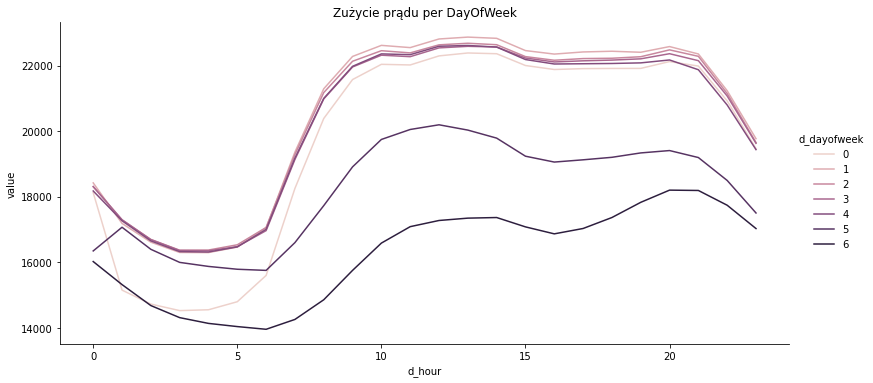

In [4]:
_ = df_all\
    .groupby(['d_hour', 'd_dayofweek'], as_index=False)\
    .agg({'value':'mean'})
sns.relplot(x="d_hour", y="value", hue='d_dayofweek', kind="line", data=_, aspect=2.2);

plt.title('Zużycie prądu per DayOfWeek');

In [5]:
holidays_pl = [
              '2019-01-01','2020-01-01','2021-01-01','2022-01-01',
              '2019-01-06','2020-01-06','2021-01-06','2022-01-06',
              '2019-05-01','2020-05-01','2021-05-01','2022-05-01',
              '2019-05-03','2020-05-03','2021-05-03','2022-05-03',
              '2019-08-15','2020-08-15','2021-08-15','2018-08-15',
              '2019-11-01','2020-11-01','2021-11-01','2018-11-01',
              '2019-11-11','2020-11-11','2021-11-11','2018-11-11',
              '2019-12-25','2020-12-25','2021-12-25','2018-12-25',
              '2019-12-26','2020-12-26','2021-12-26','2018-12-26',
              '2018-04-01','2018-04-02','2018-05-20','2018-05-31',
              '2019-04-21','2019-04-22','2019-06-09','2019-06-20',
              '2020-04-12','2020-04-13','2020-05-31','2020-06-11',
              '2021-04-04','2021-04-05','2020-05-23','2020-06-03'
              ]
day_before_holidays_pl = [
                '2019-12-31','2020-12-31','2021-12-31','2018-12-31',
                '2019-01-05','2020-01-05','2021-01-05','2022-01-05',
                '2019-04-30','2020-04-30','2021-04-30','2022-04-30',
                '2019-05-02','2020-05-02','2021-05-02','2022-05-02',
                '2019-08-14','2020-08-14','2021-08-14','2018-08-14',
                '2019-10-31','2020-10-31','2021-10-31','2018-10-31',
                '2019-11-10','2020-11-10','2021-11-10','2018-11-10',
                '2019-12-24','2020-12-24','2021-12-24','2018-12-24',
                '2018-03-31','2018-05-21','2018-05-30', #  zamiast '2018-05-21' powinno być '2018-05-19' 
                '2019-04-20','2019-06-08','2019-06-19',
                '2020-04-11','2020-05-30','2020-06-10',
                '2021-04-03','2020-05-22','2020-06-02'
              ]
day_after_holidays_pl = [
                '2019-01-02','2020-01-02','2021-01-02','2022-01-02',
                '2019-01-07','2020-01-07','2021-01-07','2022-01-07',
                '2019-05-02','2020-05-02','2021-05-02','2022-05-02',
                '2019-05-04','2020-05-04','2021-05-04','2022-05-04',
                '2019-08-16','2020-08-16','2021-08-16','2018-08-16',
                '2019-11-02','2020-11-02','2021-11-02','2018-11-02',
                '2019-11-12','2020-11-12','2021-11-12','2018-11-12',
                '2019-12-27','2020-12-27','2021-12-27','2018-12-27',
                '2018-04-03','2018-05-21','2018-06-01',
                '2019-04-23','2019-06-10','2019-06-21',
                '2020-04-14','2020-06-01','2020-06-12',
                '2021-04-06','2020-05-24','2020-06-04'
              ]
df_all['holidays'] = df_all['d_date'].apply(lambda x: 1 if str(x) in holidays_pl else 0)
df_all['day_before_holidays'] = df_all['d_date'].apply(lambda x: 1 if str(x) in day_before_holidays_pl else 0)
df_all['day_after_holidays'] = df_all['d_date'].apply(lambda x: 1 if str(x) in day_after_holidays_pl else 0)

In [6]:
df_all['holidays1'] = df_all['d_date'].apply(lambda x: 2 if str(x) in holidays_pl else 
                                                       1 if str(x) in day_before_holidays_pl else
                                                       3 if str(x) in day_after_holidays_pl else 
                                                       0
                                            )

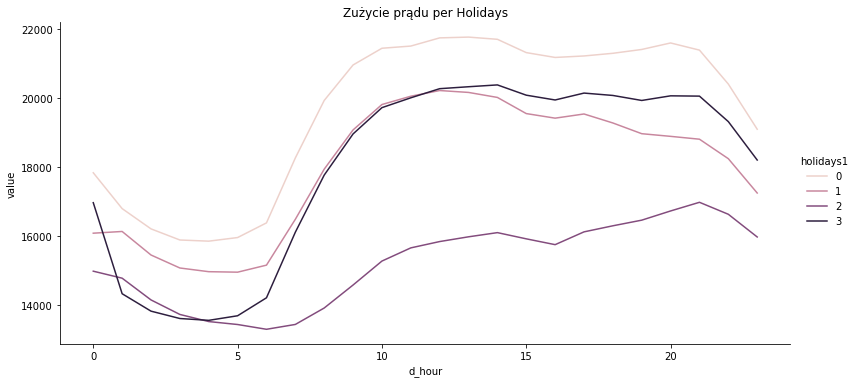

In [7]:
_ = df_all\
    .groupby(['d_hour', 'holidays1'], as_index=False)\
    .agg({'value':'mean'})
sns.relplot(x="d_hour", y="value", hue='holidays1', kind="line", data=_, aspect=2.2);

plt.title('Zużycie prądu per Holidays');

In [8]:
#podzial na 8 sezonów wzgledem pór roku
df_all['d_season8'] = df_all['d_dayofyear'].apply(lambda x: 
                              1 if x<36 else 
                              2 if x<81 else
                              3 if x<128 else
                              4 if x<174 else
                              5 if x<221 else
                              6 if x<267 else
                              7 if x<312 else
                              8 if x<357 else 1
                             )

#1	0	35   1/01-4/02  zima1
#2	36	80   5/02-21/03 zima2
#3	81	127 22/03-07/05 wiosna1
#4	128	173 08/05-22/06 wiosna2
#5	174	220 23/06-06/08 lato1
#6	221	266 07/08-23/09 lato2
#7	267	311 24/09-06/11 jesien1
#8	312	356 07/11-22/12 jesien2
#1	357	366 23/12-31/12 zima1

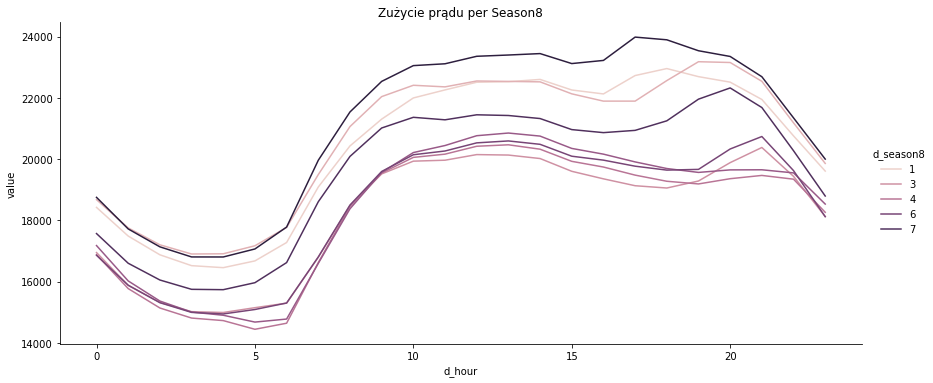

In [9]:
_ = df_all\
    .groupby(['d_hour', 'd_season8'], as_index=False)\
    .agg({'value':'mean'})
sns.relplot(x="d_hour", y="value", hue='d_season8', kind="line", data=_, aspect=2.4); #

plt.title('Zużycie prądu per Season8');

In [10]:
df_all['workday'] = df_all['d_dayofweek'].apply(lambda x: 1 if x in [0,1,2,3,4] else 0)
df_all['workday'] = df_all.apply(lambda x: 0 if x['holidays'] == 1 else x['workday'], axis=1)

In [11]:
obj_feats = df_all.select_dtypes(include=['number', 'bool']).columns
black_list = ['id', 'value', 'date', 'holidays1']#, 'data_unseen' ]
feats0 = [x for x in obj_feats if x not in black_list]
feats0

['d_year',
 'd_month',
 'd_day',
 'd_dayofyear',
 'd_week',
 'd_dayofweek',
 'd_quarter',
 'd_season',
 'd_hour',
 'holidays',
 'day_before_holidays',
 'day_after_holidays',
 'd_season8',
 'workday']

In [12]:
df_train = df_all[ df_all["value"].notnull() ].copy()
df_test = df_all[ df_all["value"].isnull() ]

X_train = df_train[feats0]
y_train = df_train['value']
X_test = df_test[feats0]

In [13]:
def get_models():
    xgb_params = {    
        'max_depth': 7, 
        'n_estimators': 100,
        'learning_rate': 0.15, 
        'subsample': 0.6, 
        'random_state':123, 
        'colsample_bytree': 0.85
    }
    ctb_params = {
        'n_estimators': 100, 
        'depth': 7, 
        'random_state':123, 
        'verbose': False
    }
    return [
         ('xgb', xgb.XGBRegressor(**xgb_params)),
         ('ctb', ctb.CatBoostRegressor(**ctb_params))
     ]

def run_cv(model, X, y, folds=3, cv_type=GroupKFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds) 
    scores = cross_val_score(model, X, y, groups=df_train["d_date"], cv=cv, scoring="neg_mean_absolute_error")
    return np.mean(scores), np.std(scores)

def run(X, y, folds=3):
    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds)
        print(f'[{model_name}]: {score_mean} +/-{score_std}')
        sys.stdout.flush()

In [14]:
run(df_train[feats0].values, df_train['value'].values, folds=5)

[xgb]: -362.97112477586245 +/-5.644064177523832
[ctb]: -367.2332355268736 +/-10.1759045454454


In [15]:
def objective(params):
    classifier_type = params['type']
    del params['type']
    if classifier_type == 'xgb':
        clf = xgb.XGBRegressor(**params)
    elif classifier_type == 'xgb1':
        clf = xgb.XGBRegressor(**params)
    else:
        return 0
    cv = GroupKFold(n_splits=5)
    score = cross_val_score(clf, X_train, y_train, groups=df_train["d_date"], cv=cv, scoring="neg_mean_absolute_error").mean()
    return {'loss': -score, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'xgb1',
        'colsample_bytree' : hp.quniform ('x_colsample_bytree', 0.80, 0.9, 0.05),
        'learning_rate': hp.quniform('x_learning_rate', 0.10, 0.2, 0.05),
        'max_depth': 7, #hp.choice('x_max_depth', np.arange(5, 20, dtype=int)),
        'random_state': 123,
        'subsample': 0.7, #hp.quniform ('x_subsample', 0.7, 1., 0.1),
        'n_estimators': 290, #hp.choice('x_n_estimators',np.arange(200, 300, dtype=int))
    }
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn = objective, 
        space = search_space,
        algo = algo,
        max_evals = 10,
        trials = trials)
print(space_eval(search_space, best_result))

100%|██████████| 10/10 [05:55<00:00, 35.58s/trial, best loss: 340.4724778184677]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 290, 'random_state': 123, 'subsample': 0.7, 'type': 'xgb1'}


In [16]:
xgb_best_params = {
                   'learning_rate': 0.15, 
                   'max_depth': 7,
                   'random_state': 123, 
                   'subsample': 0.7,
                   'n_estimators': 290
                    }

In [17]:
model = xgb.XGBRegressor(**xgb_best_params)
model.fit(X_train, y_train)
y_pred_final = model.predict(X_test)

eli5.show_weights(model, feature_names=feats0)

Weight,Feature
0.7141,workday
0.1327,d_season
0.0443,d_season8
0.0301,holidays
0.0295,d_hour
0.0129,d_week
0.0086,day_after_holidays
0.0079,day_before_holidays
0.0068,d_dayofyear
0.0063,d_dayofweek


In [18]:
!mkdir -p ../output

In [19]:
df_test['value'] = y_pred_final
df_test[ ["id", "value"] ].to_csv("../output/final.csv", index=False)

<ipython-input-19-edaf606137a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['value'] = y_pred_final
